In [1]:
import ast
import numpy as np
import pandas as pd
import seaborn as sns 
from datasets import load_dataset
import matplotlib.pyplot as plt 
from matplotlib.ticker import PercentFormatter
from adjustText import adjust_text

# Loading the Dataset 
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Initial Clean-up
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

In [2]:
countries = ['United Kingdom', 'France', 'Netherlands', 'Germany', 'Belgium']

df_da_eu = df[(df['job_country'].isin(countries)) & (df['job_title_short'] == 'Data Analyst')]

In [3]:
df_da_eu = df_da_eu.dropna(subset='salary_year_avg')

df_da_eu_exp = df_da_eu.explode('job_skills')

df_da_eu_exp[['salary_year_avg', 'job_skills']].head()

,salary_year_avg,job_skills
2602,51014.0,excel
2602,51014.0,word
2602,51014.0,outlook
12526,111175.0,power bi
12526,111175.0,sharepoint


In [4]:
len(df_da_eu)

210

In [5]:
df_da_skills = df_da_eu_exp.groupby('job_skills')['salary_year_avg'].agg(['count', 'median']).sort_values(by='count', ascending=False)

df_da_skills.rename(columns={'median': 'median_salary', 'count': 'skill_count'}, inplace=True)

df_da_skills.head(10)





,skill_count,median_salary
job_skills,,
sql,103,98500.0
python,77,98500.0
excel,57,80850.0
tableau,47,98500.0
r,28,89152.0
azure,27,89100.0
power bi,26,89100.0
go,23,57500.0
aws,17,111175.0


In [6]:
da_job_count = len(df_da_eu)

df_da_skills['skill_percent'] = df_da_skills['skill_count'] / da_job_count * 100

df_da_skills['skill_percent_f'] = df_da_skills['skill_percent'].apply(lambda x: f'{x:.2f}%')

df_da_skills = df_da_skills.head(12).copy()
df_da_skills = df_da_skills.drop(index=['go', 'sas'])


In [7]:
df_da_skills

,skill_count,median_salary,skill_percent,skill_percent_f
job_skills,,,,
sql,103,98500.0,49.047619,49.05%
python,77,98500.0,36.666667,36.67%
excel,57,80850.0,27.142857,27.14%
tableau,47,98500.0,22.380952,22.38%
r,28,89152.0,13.333333,13.33%
azure,27,89100.0,12.857143,12.86%
power bi,26,89100.0,12.380952,12.38%
aws,17,111175.0,8.095238,8.10%
spark,17,111175.0,8.095238,8.10%


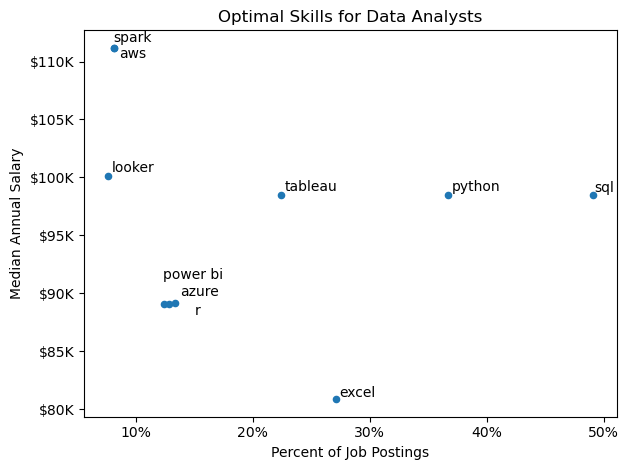

In [8]:
df_da_skills.plot(kind='scatter', x='skill_percent', y='median_salary')

texts = []

for i, txt in enumerate(df_da_skills.index):
    texts.append(plt.text(df_da_skills['skill_percent'].iloc[i], df_da_skills['median_salary'].iloc[i], txt))

adjust_text(texts)

plt.xlabel('Percent of Job Postings')
plt.ylabel('Median Annual Salary')
plt.title('Optimal Skills for Data Analysts')

ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'${int(y/1000)}K'))
ax.xaxis.set_major_formatter(PercentFormatter(decimals=0))

plt.tight_layout()
plt.show()

In [9]:
skill_type = {
    'programming': ['sql', 'python', 'r'],
    'analyst_tools': ['excel', 'power bi', 'tableau', 'spark', 'looker'],
    'cloud': ['aws', 'azure']
}

In [10]:
df_skill_type = pd.DataFrame(list(skill_type.items()), columns=['technology', 'skills'])

In [11]:
df_skill_type

,technology,skills
0,programming,"[sql, python, r]"
1,analyst_tools,"[excel, power bi, tableau, spark, looker]"
2,cloud,"[aws, azure]"


In [12]:
df_skill_type_exp = df_skill_type.explode('skills')

In [13]:
df_skill_type_exp

,technology,skills
0,programming,sql
0,programming,python
0,programming,r
1,analyst_tools,excel
1,analyst_tools,power bi
1,analyst_tools,tableau
1,analyst_tools,spark
1,analyst_tools,looker
2,cloud,aws
2,cloud,azure


In [14]:
df_plot = df_da_skills.merge(df_skill_type_exp, left_on='job_skills', right_on='skills')

In [15]:
df_plot['median_salary_jittered'] = df_plot['median_salary'] + np.random.uniform(-100, 100, size=len(df_plot))

In [16]:
df_plot

,skill_count,median_salary,skill_percent,skill_percent_f,technology,skills,median_salary_jittered
0,103,98500.0,49.047619,49.05%,programming,sql,98535.734777
1,77,98500.0,36.666667,36.67%,programming,python,98590.650173
2,57,80850.0,27.142857,27.14%,analyst_tools,excel,80762.535392
3,47,98500.0,22.380952,22.38%,analyst_tools,tableau,98460.168675
4,28,89152.0,13.333333,13.33%,programming,r,89167.073536
5,27,89100.0,12.857143,12.86%,cloud,azure,89162.741604
6,26,89100.0,12.380952,12.38%,analyst_tools,power bi,89150.553879
7,17,111175.0,8.095238,8.10%,cloud,aws,111210.184573
8,17,111175.0,8.095238,8.10%,analyst_tools,spark,111192.773855
9,16,100137.5,7.619048,7.62%,analyst_tools,looker,100130.473248


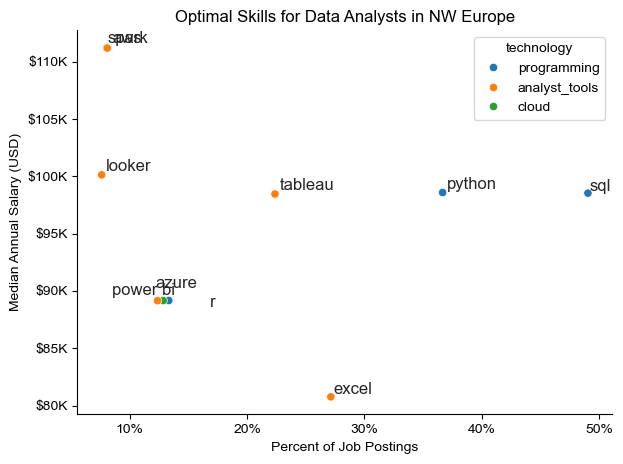

In [17]:
# df_da_skills.plot(kind='scatter', x='skill_percent', y='median_salary')
sns.scatterplot(
    data=df_plot,
    x='skill_percent',
    y='median_salary_jittered',
    hue='technology',
)

sns.despine()
sns.set_theme(style='ticks')

texts = []

for i, txt in enumerate(df_plot['skills']):
    x = df_plot['skill_percent'].iloc[i]
    y = df_plot['median_salary_jittered'].iloc[i]
    if txt == 'spark':
        y -= 250  # nudge spark label up
    elif txt == 'aws':
        y += 250  # nudge aws label down
    #texts.append(plt.text(df_plot['skill_percent'].iloc[i], df_plot['median_salary_jittered'].iloc[i], txt))
    texts.append(plt.text(x, y, txt))


adjust_text(texts, 
            only_move={'points':'y', 'texts':'y'}
            )

plt.xlabel('Percent of Job Postings')
plt.ylabel('Median Annual Salary (USD)')
plt.title('Optimal Skills for Data Analysts in NW Europe')

ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'${int(y/1000)}K'))
ax.xaxis.set_major_formatter(PercentFormatter(decimals=0))

plt.tight_layout()
plt.show()